In [5]:
import torch
from PIL import ImageChops
from util import fake_image, AddBackground_v3, read_root
from random import choice, randint, sample
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms.functional import to_pil_image, pil_to_tensor, resized_crop
from torchvision.transforms.v2 import Compose, Resize, ToImage, ToPILImage, ToDtype, ScaleJitter, RandomResize, RandomRotation, RandomAffine, RandomPerspective, ColorJitter, ConvertBoundingBoxFormat, RandomResizedCrop

# card_transform = Compose([
#     RandomResize(50, 224),
#     ColorJitter(brightness=(0.5, 1.0), contrast=(0.5, 1.0)),
#     RandomRotation(30, expand=True),
#     RandomPerspective(0.3),
# ])

# cards = ImageFolder(r'../data/playing_cards', transform=card_transform)
# choice(cards)[0]
card_classes = ImageFolder(r'../data/playing_cards').classes

In [ ]:
from pathlib import Path
from PIL import Image
class RandomBackground(torch.nn.Module):
    def __init__(self, source, size=640, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.files = list(Path(source).glob('*.jpg'))
        self.crop = RandomResizedCrop(size)
    
    def forward(self):
        path = choice(self.files)
        with open(path, "rb") as f:
            img = Image.open(f)
            return self.crop(img.convert("RGB"))

def read_root(root, size=None, labels=None):
    if size is not None:
        resize = Resize(size)
    imgs = []
    for path in root.glob('**/*.jpg'):
        with open(path, "rb") as f:
            img = Image.open(f)
            if size is not None:
                img = resize(img)
            if labels is not None:
                imgs.append(((img.convert("RGB")), labels.index(path.stem)))
            else:
                imgs.append(img.convert("RGB"))
    return imgs
random_background = read_root(Path(r'../data/sample_images'), size=640)
cards = read_root(Path(r'../data/playing_cards'), size=224, include_label=True)

In [ ]:
rcrop = RandomResizedCrop(640)
transform = card_transform
img = choice(cards)[0]
img = card_transform(img)
height, width = img.height, img.width
x = randint(0, 448-width)
y = randint(0, 448-height)
background = pil_to_tensor(rcrop(choice(random_background)))
img = pil_to_tensor(img)
mask = torch.zeros_like(background)
mask[:, y:y+height, x:x+width] = img
background[:, (mask >  0).any(0)] = 0
final = mask | background
to_pil_image(final)

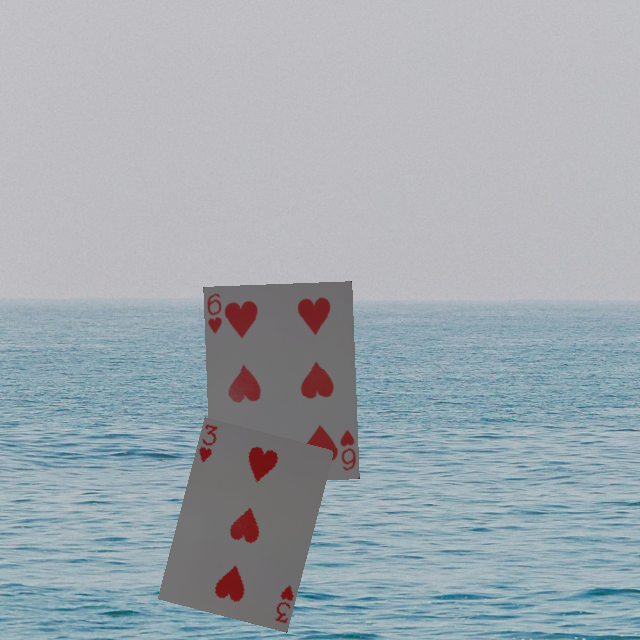

In [82]:

class AddBackground_v3(torch.nn.Module):
    def __init__(self, width=640, height=640, PIL=True) -> None:
        super().__init__()
        self.width = width
        self.height = height
        self.PIL = PIL

    def forward(self, samples, background):
        background = pil_to_tensor(background) #(self.height, self.width, PIL=False)
        labels = []
        for img, label in samples:
            img = card_transform(img)
            height, width = img.height, img.width
            x = randint(0, self.width-width)
            y = randint(0, self.height-height)
            img = pil_to_tensor(img)
            mask = torch.zeros_like(background)
            mask[:, y:y+height, x:x+width] = img
            background[:, (mask >  0).any(0)] = 0
            background = mask | background
            cx = (x + width // 2) / self.width
            cy = (y + height // 2) / self.height
            labels.append(f'{label} {cx} {cy} {width / self.width} {height / self.height}')  # class cx cy width height
        if self.PIL:
            return to_pil_image(background), '\n'.join(labels)
        return background, '\n'.join(labels)
add = AddBackground_v3(PIL=True)
card_imgs = sample(cards, randint(1, 4))
add(card_imgs, rcrop(choice(random_background)))[0]

In [7]:
from pathlib import Path
random_background = read_root(Path(r'../data/sample_images'), size=640)
cards = read_root(Path(r'../data/playing_cards'), size=224, labels=card_classes)

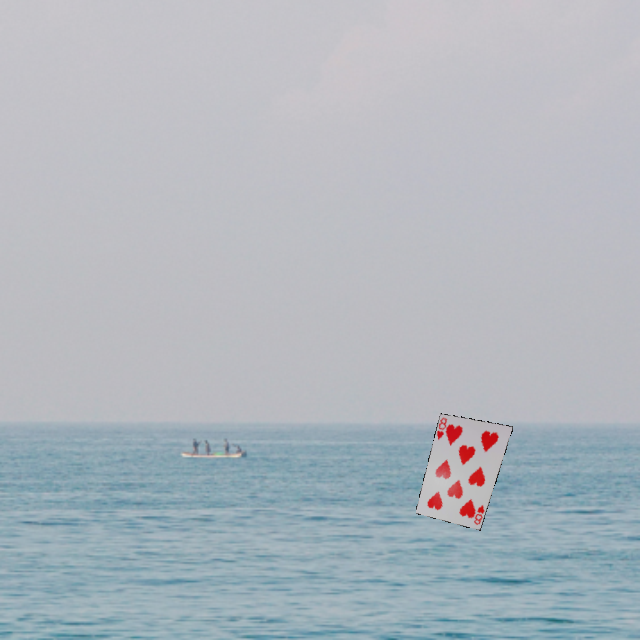

'37 0.7171875 0.73125 0.178125 0.215625'

In [8]:

rcrop = RandomResizedCrop(640)
add = AddBackground_v3(PIL=True)
card_imgs = sample(cards, randint(1, 4))
display(*add(card_imgs, rcrop(choice(random_background))))